# Regularized Linear Regression 

**This competition helps alot to understand the methodology of a Data Science project and is a good option as a starter in this field.**

#### Importing some important libraries to work with

In [48]:
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import norm
import time

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

#import os
#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

**Load datasets.**

In [49]:
train= pd.read_csv('C://Users/Saba Naseem/Desktop/kaggle/House Price Predicion/train.csv')
test= pd.read_csv('C://Users/Saba Naseem/Desktop/kaggle/House Price Predicion/test.csv')

print("shape of train dataset:", train.shape)
print("shape of test dataset:", test.shape)

shape of train dataset: (1460, 81)
shape of test dataset: (1459, 80)


In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 1. Exploratory Data Analysis

### Visualization of target variable SalePrice data distribution.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


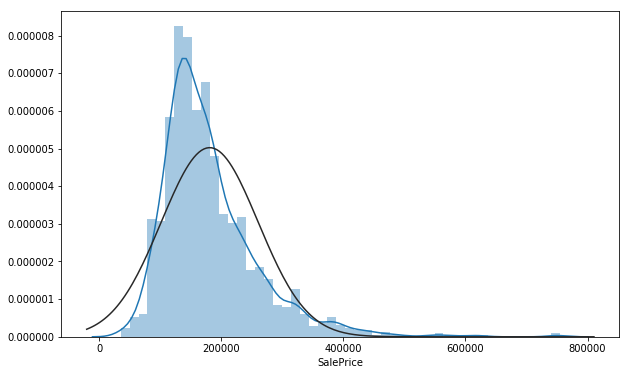

In [4]:
plt.figure(figsize=[10,6])
sns.distplot(train.SalePrice, fit=norm)

The target variable is right skewed. So we need to transform this variable and make it more normally distributed.

In case of positive skewness, log transformation works well.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


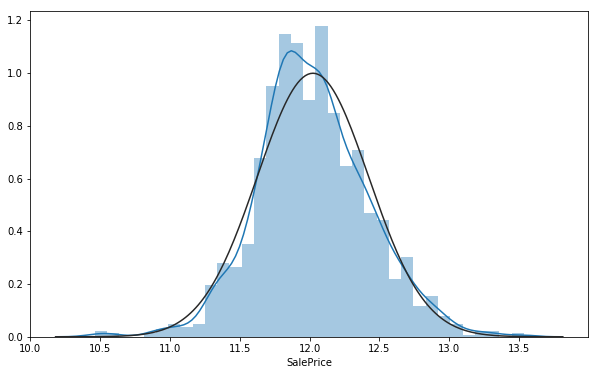

In [5]:
plt.figure(figsize=[10,6])
sns.distplot(np.log(train.SalePrice), fit=norm)

The data is now normally distributed as we corrected skew.

### Let's visualize relationship of features with SalePrice using Seaborn's Heatmap

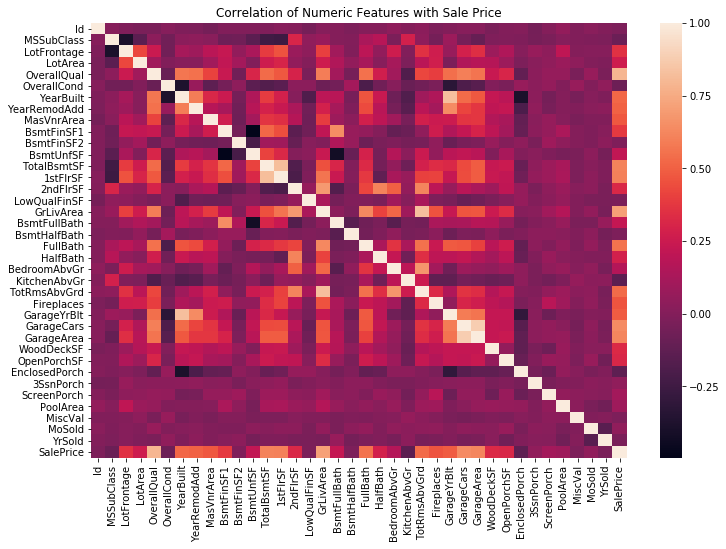

In [5]:
correlation= train.corr()
plt.figure(figsize=[12,8])
plt.title('Correlation of Numeric Features with Sale Price')
sns.heatmap(correlation)

In [50]:
correlation= train.corr()
correlation=correlation['SalePrice'].sort_values(ascending=False)
pos_correlation=correlation.head(25)
pos_correlation

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.351799
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
HalfBath        0.284108
LotArea         0.263843
BsmtFullBath    0.227122
BsmtUnfSF       0.214479
BedroomAbvGr    0.168213
ScreenPorch     0.111447
Name: SalePrice, dtype: float64

#### Visualizing some highly correlated features to get better understanding.

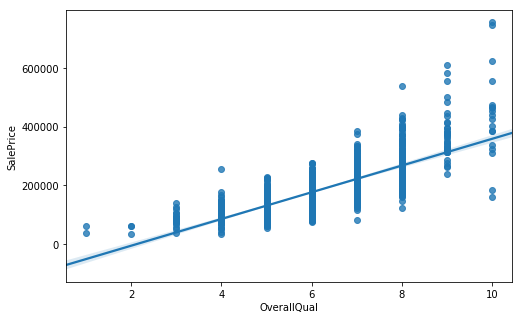

In [7]:
plt.figure(figsize=[8,5])
sns.regplot(train['OverallQual'], train['SalePrice'])

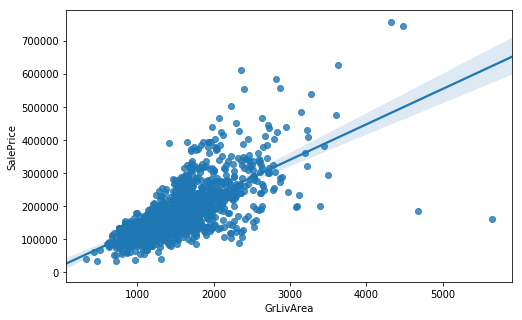

In [9]:
plt.figure(figsize=[8,5])
sns.regplot(train['GrLivArea'], train['SalePrice'])

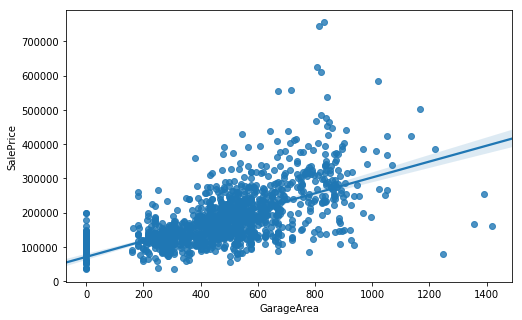

In [10]:
plt.figure(figsize=[8,5])
sns.regplot(train['GarageArea'], train['SalePrice'])

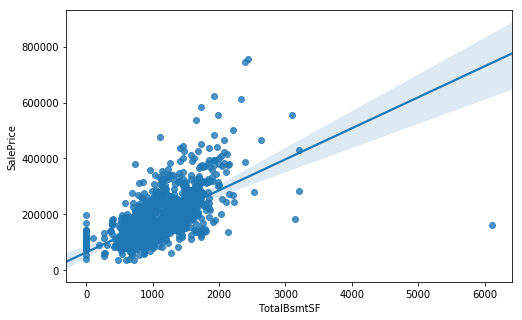

In [11]:
plt.figure(figsize=[8,5])
sns.regplot(train['TotalBsmtSF'], train['SalePrice'])

## 2. Dealing with Outliers

### We got some outliers. Let's get rid of these outliers!

In [51]:
print("Before:",train.shape)

train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index, inplace=True)
train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index, inplace=True)
train.drop(train[(train['GarageArea']>1200) & (train['SalePrice']<100000)].index, inplace=True)
train.drop(train[(train['TotalBsmtSF']>6000) & (train['SalePrice']<200000)].index, inplace=True)
train.reset_index(drop=True, inplace=True)

print("After:",train.shape)

Before: (1460, 81)
After: (1456, 81)


 ### Drop features having weak relationship with SalePrice. We don't need them!

In [52]:
weak= correlation[correlation<0.2].keys()
weak

Index(['BedroomAbvGr', 'ScreenPorch', 'PoolArea', 'MoSold', '3SsnPorch',
       'BsmtFinSF2', 'BsmtHalfBath', 'MiscVal', 'Id', 'LowQualFinSF', 'YrSold',
       'OverallCond', 'MSSubClass', 'EnclosedPorch', 'KitchenAbvGr'],
      dtype='object')

In [53]:
weak=['BedroomAbvGr', 'ScreenPorch', 'PoolArea', 'MoSold', '3SsnPorch',
       'BsmtFinSF2', 'BsmtHalfBath', 'MiscVal', 'LowQualFinSF', 'YrSold',
       'OverallCond', 'MSSubClass', 'EnclosedPorch', 'KitchenAbvGr']

In [54]:
print("Brfore:", train.shape)
train.drop(weak, axis=1, inplace=True)
test.drop(weak, axis=1, inplace=True)
print("Brfore:", train.shape)

Brfore: (1456, 81)
Brfore: (1456, 67)


## 3. Feature Engineering and Data Cleaning

### Let's move to handle missing values

In [55]:
data= pd.concat([train.drop(['SalePrice'], axis=1), test])

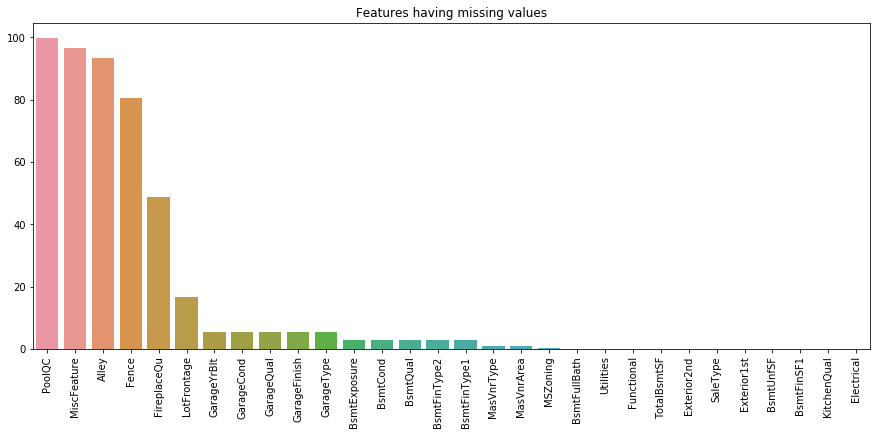

In [22]:
xx= (data.isnull().sum())/len(data)*100
xx=xx.sort_values(ascending=False).head(30)

plt.figure(figsize=(15, 6))
plt.title("Features having missing values")
plt.xticks(rotation="90")
sns.barplot(xx.keys(), xx)

### Get percentage of these missing values in features

In [23]:
total=data.isnull().sum().sort_values(ascending=False)
percent=((data.isnull().sum()/data.isnull().count())*100).sort_values(ascending=False)
missing= pd.concat([total,percent], axis=1, join='outer', keys=['Total missing count', 'Percentage '])
missing.head(30)

,Total missing count,Percentage
PoolQC,2906,99.691252
MiscFeature,2811,96.432247
Alley,2717,93.207547
Fence,2344,80.411664
FireplaceQu,1419,48.679245
LotFrontage,485,16.638079
GarageYrBlt,159,5.454545
GarageCond,159,5.454545
GarageQual,159,5.454545
GarageFinish,159,5.454545


### Updating FireplaceQu

In [18]:
data['FireplaceQu'].unique()

array([nan, 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

 `nan` means `not a number`

nan FireplaceQu means no Fireplaces at all, let's fill it with 'None'

In [68]:
train['FireplaceQu'].fillna('None', inplace=True)
test['FireplaceQu'].fillna('None', inplace=True)

### Updating LotFrontage

In [20]:
data['LotFrontage'].describe()

count    2428.000000
mean       69.060544
std        22.237973
min        21.000000
25%        59.000000
50%        68.000000
75%        80.000000
max       200.000000
Name: LotFrontage, dtype: float64

Fill them with mean.

In [67]:
train['LotFrontage'].fillna(69, inplace=True)
test['LotFrontage'].fillna(69, inplace=True)

### Updating Garage features


Fill all missing values of Garage features with 'None' as they have no Garage.

In [66]:
train['GarageQual'].fillna('None', inplace=True)
test['GarageQual'].fillna('None', inplace=True)
train['GarageFinish'].fillna('None', inplace=True)
test['GarageFinish'].fillna('None', inplace=True)
train['GarageYrBlt'].fillna('None', inplace=True)
test['GarageYrBlt'].fillna('None', inplace=True)
train['GarageType'].fillna('None', inplace=True)
test['GarageType'].fillna('None', inplace=True)
train['GarageCond'].fillna('None', inplace=True)
test['GarageCond'].fillna('None', inplace=True)
test.loc[test['Id']==2577, 'GarageType']='None'

### Updating Basement features

Let's first have a look at BsmtCond. There are some rows having Basement but no Basement condition. Let's dig out more.

In [24]:
data[(data['TotalBsmtSF']!=0) & (data['BsmtCond'].isnull()==True)][['Id','TotalBsmtSF','BsmtCond','BsmtQual','BsmtExposure',
                                                                    'BsmtFinType1','BsmtFinSF1','BsmtUnfSF']]

,Id,TotalBsmtSF,BsmtCond,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtUnfSF
580,2041,1426.0,NaN,Gd,Mn,GLQ,1044.0,0.0
660,2121,NaN,NaN,NaN,NaN,NaN,NaN,NaN
725,2186,1127.0,NaN,TA,No,BLQ,1033.0,94.0
1064,2525,995.0,NaN,TA,Av,ALQ,755.0,240.0


Fill these BsmtCond null values with BsmtQual and others with None as they have no Basement at all.

In [65]:
test.loc[test['Id']==2041, 'BsmtCond']='Gd'
test.loc[test['Id']==2186, 'BsmtCond']='TA'
test.loc[test['Id']==2525, 'BsmtCond']='TA'
train['BsmtCond'].fillna('None', inplace=True)
test['BsmtCond'].fillna('None', inplace=True)

In [26]:
data[(data['TotalBsmtSF']!=0) & (data['BsmtExposure'].isnull()==True)][['Id','TotalBsmtSF','BsmtCond','BsmtQual','BsmtExposure',
                                                                    'BsmtFinType1','BsmtFinSF1','BsmtUnfSF']]

,Id,TotalBsmtSF,BsmtCond,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtUnfSF
944,949,936.0,TA,Gd,NaN,Unf,0.0,936.0
27,1488,1595.0,TA,Gd,NaN,Unf,0.0,1595.0
660,2121,NaN,NaN,NaN,NaN,NaN,NaN,NaN
888,2349,725.0,TA,Gd,NaN,Unf,0.0,725.0


Fill these BsmtExposure null values with values of BsmtQual and other with None.

In [64]:
train.loc[train['Id']==949, 'BsmtExposure']='Gd'
test.loc[test['Id']==1488, 'BsmtExposure']='Gd'
test.loc[test['Id']==2349, 'BsmtExposure']='Gd'
train['BsmtExposure'].fillna('None', inplace=True)
test['BsmtExposure'].fillna('None', inplace=True)

In [28]:
data[(data['TotalBsmtSF']!=0) & (data['BsmtQual'].isnull()==True)][['Id','TotalBsmtSF','BsmtQual','BsmtCond','BsmtExposure',
                                                                    'BsmtFinType1','BsmtFinSF1','BsmtUnfSF']]

,Id,TotalBsmtSF,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtUnfSF
660,2121,NaN,NaN,NaN,NaN,NaN,NaN,NaN
757,2218,173.0,NaN,Fa,No,Unf,0.0,173.0
758,2219,356.0,NaN,TA,No,Unf,0.0,356.0


Fill these BsmtQual null values with values of BsmtCond and others with None.

In [63]:
test.loc[test['Id']==2218, 'BsmtQual']='Fa'
test.loc[test['Id']==2219, 'BsmtQual']='TA'
train['BsmtQual'].fillna('None', inplace=True)
test['BsmtQual'].fillna('None', inplace=True)

In [30]:
data[(data['TotalBsmtSF']!=0) & (data['BsmtFinType1'].isnull()==True)][['Id','TotalBsmtSF','BsmtQual','BsmtCond','BsmtExposure',
                                                                        'BsmtFinType1','BsmtFinSF1','BsmtUnfSF']]

,Id,TotalBsmtSF,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtUnfSF
660,2121,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
data[(data['TotalBsmtSF']!=0) & (data['BsmtFullBath'].isnull()==True)][['Id','TotalBsmtSF','BsmtQual','BsmtCond',
                                                                        'BsmtExposure','BsmtFullBath']]

,Id,TotalBsmtSF,BsmtQual,BsmtCond,BsmtExposure,BsmtFullBath
660,2121,NaN,NaN,NaN,NaN,NaN


Fill all other Basement features missing values with None or Zero.

In [62]:
train['BsmtFinType1'].fillna('None', inplace=True)
test['BsmtFinType1'].fillna('None', inplace=True)
test['BsmtFinSF1'].fillna(0, inplace=True)
test['BsmtUnfSF'].fillna(0, inplace=True)
test['TotalBsmtSF'].fillna(0, inplace=True)
test['BsmtFullBath'].fillna(0, inplace=True)

### Updating MasVnrType and MasVnrArea

In [61]:
train['MasVnrType'].fillna('None', inplace=True)
test['MasVnrType'].fillna('None', inplace=True)
train['MasVnrArea'].fillna(0, inplace=True)
test['MasVnrArea'].fillna(0, inplace=True)

### Updating MSZoning

In [34]:
test['MSZoning'].mode()

0    RL
dtype: object

In [60]:
test['MSZoning'].fillna("RL", inplace=True)

### Updating GarageCars and GarageArea

Fill them with zero

In [59]:
test['GarageCars'].fillna(0, inplace=True)
test['GarageArea'].fillna(0, inplace=True)

### Updating Functional, SaleType, Exterior1st, KitchenQual, Exterior2nd

Fill them with their mode

In [58]:
test['Functional'].fillna('Typ', inplace=True)
test['SaleType'].fillna('WD', inplace=True)
test['Exterior1st'].fillna('VinylSd', inplace=True)
test['KitchenQual'].fillna('TA', inplace=True)
test['Exterior2nd'].fillna('VinylSd', inplace=True)

### Drop some features having almost no impact on SalePrice.

In [56]:
print("Before:", train.shape,test.shape)
train.drop(['Alley','Fence', 'Utilities','MiscFeature', 'Electrical','Condition1','Condition2','BsmtFinType2',
            'Street', 'CentralAir','PoolQC'], axis=1, inplace=True)
test.drop(['Alley','Fence', 'Utilities','MiscFeature', 'Electrical','Condition1','Condition2','BsmtFinType2',
           'Street','CentralAir','PoolQC'], axis=1, inplace=True)
print("After:", train.shape, test.shape)

Before: (1456, 67) (1459, 66)
After: (1456, 56) (1459, 55)


### Check again if we have any feature left with missing vale.

In [69]:
print("Train dataset:\n",train.isnull().sum().sort_values(ascending=False).head(5))
print("\n\nTest dataset:\n",test.isnull().sum().sort_values(ascending=False).head(5))

Train dataset:
 SalePrice        0
SaleCondition    0
BsmtExposure     0
BsmtCond         0
BsmtQual         0
dtype: int64


Test dataset:
 SaleCondition    0
YearRemodAdd     0
BsmtCond         0
BsmtQual         0
Foundation       0
dtype: int64


Data is cleaned now!

In [70]:
train.shape, test.shape

((1456, 56), (1459, 55))

## 4. Features Transformation

### Apply log transformation to some features.

In [71]:
transform=['GrLivArea', 'TotalBsmtSF' ,'GarageArea', '1stFlrSF']

train[transform]= np.log(train[transform]+1)
test[transform]= np.log(test[transform]+1)

### Transform categorical features values into dummies.

In [72]:
X_train = pd.get_dummies(pd.concat((train.drop(["SalePrice", "Id"], axis=1),
                                          test.drop(["Id"], axis=1)), axis=0)).iloc[: train.shape[0]]

X_test = pd.get_dummies(pd.concat((train.drop(["SalePrice", "Id"], axis=1),
                                         test.drop(["Id"], axis=1)), axis=0)).iloc[train.shape[0]:]

X_train.shape, X_test.shape

((1456, 338), (1459, 338))

### Storing Dataset's values in arrays to feed them in model

In [73]:
y=np.asarray(train['SalePrice'])
y=np.log(y+1)  #Apply log transform on target  
print(y[:5])

[12.24769912 12.10901644 12.31717117 11.84940484 12.4292202 ]


In [74]:
x_train=np.asarray(X_train)
x_test=np.asarray(X_test)
x_train.shape,y.shape

((1456, 338), (1456,))

### Split dataset into two halves, train data and validation data

In [75]:
xtrain, xval, ytrain, yval= train_test_split(x_train, y, test_size=0.2, random_state=4)
xtrain.shape, xval.shape

((1164, 338), (292, 338))

# 5. Model Building

Let's build our model using:

* Ridge
* Lasso
* Elastic Net

Using **GridSearchCV** to make process of finding the best hyperparameters simpler

### 1. Ridge Regression 

Ridge regression uses L2 penalty which means it adds penalty of `squared magnitude` of coefficients to it's `cost function`.

* **alpha** is used for regularization strength

* If it is zero, it works same as `LinearRegression`

* Increase in alpha increases smoothness (reduces complexity by decreasing variance)

* Decrease in alpha increases magnitude of coefficients (increases complexity by decreasing bias)

In [76]:
ts= time.time()

parameter=[{'alpha':[1,2,3,4,5,6,7,8,9,10]}]

RR= Ridge()

grid_RR=GridSearchCV(RR, parameter, cv=8)

grid_RR.fit(xtrain, ytrain)

print("Best score of Ridge: ",np.round(grid_RR.best_score_,4) )

print("\nIt took",np.round((time.time()-ts)/60,3),"minutes to run." )

Best score of Ridge:  0.899

It took 0.077 minutes to run.


### Evaluating model on In-Sample and Out-Sample data

* In-Sample data is data on which we have trained our model
* Out-Sample data is data our model have never seen before
* If `In-Sample score is very high and Out-Sample is very low`, it indicates that our model is suffering from `high variance` thus `overfitting`
* If ` both In-Sample and Out-Sample score is very low`, it indicates that our model is suffering from `high bias` thus `underfitting`
* If ` both In-Sample and Out-Sample scores are good and have slightly or no difference `, it indicates that our model is `just right`


### Technique to tackle the problem of model's underfitting/overfitting:

* If model is `high bias` increase it's complexity by adding more features or using higher order polynomials
* If model is `high variance` decrease it's complexity by increasing `alpha` parameter

#### Let's evaluate our model trained using Ridge Regression

In [77]:
predict1= grid_RR.predict(xtrain)

print("\nIn-Sample Score: ",np.round(r2_score(ytrain, predict1),4))
print("In-Sample logloss: ",np.round(mean_squared_error(ytrain, predict1),4))

predict2= grid_RR.predict(xval)

print("\nOut-Sample Score: ",np.round(r2_score(yval, predict2),4))
print("Out-Sample Logloss: ",np.round(mean_squared_error(yval, predict2),4))


In-Sample Score:  0.9336
In-Sample logloss:  0.0105

Out-Sample Score:  0.9346
Out-Sample Logloss:  0.0108


Score looks well!! And just a slightly difference in Insample and Outsample accuracy

### 2. Lasso Regression

Lasso (Least Absolute Shrinkage and Selection Operator) uses L1 penalty which means it adds penalty of `absolute value of magnitude` of coefficients to it's `cost function`. Unlike L2, it can lead to zero coefficients. So in this case some features are completely neglected thus less prone to overfit. By assigning zero coefficients to less important features it helps in feature selection

* **alpha** works same as `Ridge`

* If it is zero, it works same as `LinearRegression`

* Increase in alpha increases smoothness (reduces complexity by decreasing variance)

* Decrease in alpha increases magnitude of coefficients (increases complexity by decreasing bias)

In [78]:
ts= time.time()

parameter=[{'alpha':[0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009]}]

LSR = Lasso()

grid_LSR=GridSearchCV(LSR, parameter, cv=8)

grid_LSR.fit(xtrain, ytrain)

print("Best score of Lasso: ",np.round(grid_LSR.best_score_,4) )

print("\nIt took",np.round((time.time()-ts)/60,3),"minutes to run." )

Best score of Lasso:  0.902

It took 0.181 minutes to run.


### Evaluation of Lasso

In [79]:
predict1= grid_LSR.predict(xtrain)

print("\nIn-Sample Score: ",np.round(r2_score(ytrain, predict1),4))
print("In-Sample logloss: ",np.round(mean_squared_error(ytrain, predict1),4))

predict2= grid_LSR.predict(xval)

print("\nOut-Sample Score: ",np.round(r2_score(yval, predict2),4))
print("Out-Sample Logloss: ",np.round(mean_squared_error(yval, predict2),4))


In-Sample Score:  0.929
In-Sample logloss:  0.0112

Out-Sample Score:  0.9326
Out-Sample Logloss:  0.0111


### 3. ElasticNet

Elastic Net uses `both L1 and L2` penalty like it's a `combination of LASSO and Ridge`. It works well on `large datasets`

* **alpha** works same as in `Ridge and Lasso` 

* **l1_ratio** is to control penalty 

* if it is `0` , it is `L2`

* if it is `1`, it is `L1`

* if it is `0 < l1_ratio < 1`, it is combination of `L1 and L2`

In [80]:
ts= time.time()

parameter=[{"alpha": [0.001, 0.01, 0.1],
            "l1_ratio": np.arange(0.0, 1.0, 0.1)}]

EN = ElasticNet(max_iter=1000, tol=0.1)

grid_EN=GridSearchCV(EN, parameter, cv=8)

grid_EN.fit(xtrain, ytrain)

print("Best score of Elastic Net: ",np.round(grid_EN.best_score_,4) )

print("\nIt took",np.round((time.time()-ts)/60,3),"minutes to run." )

Best score of Elastic Net:  0.8808

It took 0.131 minutes to run.


### Evaluation of Elastic Net

In [81]:
predict1= grid_EN.predict(xtrain)

print("\nIn-Sample Score: ",np.round(r2_score(ytrain, predict1),4))
print("In-Sample logloss: ",np.round(mean_squared_error(ytrain, predict1),4))

predict2= grid_EN.predict(xval)

print("\nOut-Sample Score: ",np.round(r2_score(yval, predict2),4))
print("Out-Sample Logloss: ",np.round(mean_squared_error(yval, predict2),4))


In-Sample Score:  0.9065
In-Sample logloss:  0.0148

Out-Sample Score:  0.9093
Out-Sample Logloss:  0.015


### `best_estimator_` to find best hyperparameters of a model

In [82]:
grid_RR.best_estimator_

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [83]:
grid_LSR.best_estimator_

Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [84]:
grid_EN.best_estimator_

ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.8,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.1, warm_start=False)

### Let's train our model again using Ridge Regression on full data and make predictions on test data

In [85]:
RidgeRegression = Ridge(alpha=8)  #alpha=8 produced best results

RidgeRegression.fit(x_train,y)

Ridge(alpha=8, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [86]:
predict=RidgeRegression.predict(x_test)
predict= np.exp(predict)-1 #Retransforming values of SalePrice 
idd= np.asarray(test['Id'])

In [87]:
submission= pd.DataFrame({'Id':idd, 'SalePrice':predict})
submission.to_csv("submit_to_kernel.csv", index=False)

#### And its done!